# Génération de mélodies avec un GAN

Ce notebook présente l'utilisation d'un gan dans le cadre de la génération de mélodies. Il réutilise le pré-traitement effectué pour les auto-encodeur. Dans ce notebook le modèle est un gan classique mais dans le notebook gan2 plusieurs modèles de gan plus complexes sont étudiés. 

## Prétraitement 

Méthode similaire au VAE_gen2

In [1]:
## Fonctions de pré-traitement

import os
import music21 as m21

# Longueur maximale des séquences
MAX_SEQUENCE_LENGTH = 100

# Durée des notes
ACCEPTABLE_DURATIONS = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]

# Vérification de la durée des notes et suppression des éléments non conformes
def has_acceptable_durations(song, acceptable_durations):
    for note in song.flatten().notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

# Transposition en do majeur
def transpose(song, print_enabled=False):
    # transpose song in Cmaj/Amin

    # get key signature
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]
    if print_enabled : print("old key : ", key)

    # estimate key if not indicated
    if not isinstance(key, m21.key.Key):
        key = song.analyze("key")

    # get interval for transposition
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))
    
    transposed_song = song.transpose(interval)

    return transposed_song

# Encodage des mélodies en 2 séquences (notes et durées)
def encode_song(song):
    notes = []
    durations = []
    for note in song.flatten().notesAndRests:
        if isinstance(note, m21.note.Note):
            notes.append(note.pitch.midi)
            durations.append(note.duration.quarterLength)
        elif isinstance(note, m21.note.Rest):
            notes.append(99) # 99 pour les silences
            durations.append(note.duration.quarterLength)
    return notes, durations

# Fonction de décodage
def decode_song(encoded_song):
    notes = encoded_song[0]
    durations = encoded_song[1]
    decoded_song = m21.stream.Score()
    for i in range(len(notes)):
        if notes[i] == 99:
            decoded_song.append(m21.note.Rest(durations[i]))
        else:
            note = m21.note.Note()
            note.pitch.midi = notes[i]
            note.duration.quarterLength = durations[i]
            decoded_song.append(note)
    return decoded_song

# Padding
def pad_sequence(sequence, max_length):
    notes = sequence[0]
    durations = sequence[1]
    if len(notes) < max_length:
        for i in range(max_length - len(notes)):
            notes.append(99)
            durations.append(4.0)
    else :
        notes = notes[:max_length]
        durations = durations[:max_length]
    return notes, durations


# Fonction pour encoder les durées en entiers 
def encode_durations_int(duration):
    duration_int = []
    for d in duration:
        if d == 0.25:
            duration_int.append(0)
        elif d == 0.5:
            duration_int.append(1)
        elif d == 0.75:
            duration_int.append(2)
        elif d == 1.0:
            duration_int.append(3)
        elif d == 1.5:
            duration_int.append(4)
        elif d == 2.0:
            duration_int.append(5)
        elif d == 3.0:
            duration_int.append(6)
        elif d == 4.0:
            duration_int.append(7)
        else:
            print("Unknown duration : ", d)
            duration_int.append(8)
    return duration_int

# Fonction pour decoder les durées en flottants
def decode_duration_float(duration):
    float_duration = []
    for d in duration:
        if d == 0:
            float_duration.append(0.25)
        elif d == 1:
            float_duration.append(0.5)
        elif d == 2:
            float_duration.append(0.75)
        elif d == 3:
            float_duration.append(1.0)
        elif d == 4:
            float_duration.append(1.5)
        elif d == 5:
            float_duration.append(2.0)
        elif d == 6:
            float_duration.append(3.0)
        elif d == 7:
            float_duration.append(4.0)
        else:
            print("Unknown duration : ", d)
            float_duration.append(8)
    return float_duration

# Affichage du rythme et des notes au format midi 
def show_encoded_song(encoded_song):
    # Création de 2 streams
    notes_stream = m21.stream.Stream()
    durations_stream = m21.stream.Stream()

    # Notes
    notes = encoded_song[0]
    for note in notes:
        if note == 99:
            rest = m21.note.Rest()
            rest.quarterLength = 1
            notes_stream.append(rest)
        else:
            note = m21.note.Note(note)
            note.quarterLength = 1
            notes_stream.append(note)

    # Durées
    durations = encoded_song[1]
    for duration in durations:
        note = m21.note.Note(61) # DO
        note.quarterLength = duration
        durations_stream.append(note)

    # Affichage
    print("---Notes encodés---")
    notes_stream.show()
    print("---Rythmes encodés---")
    durations_stream.show()

    return notes_stream, durations_stream

In [3]:
# Sauvegarder et loader les séquences pré-traitées
import numpy as np
import pickle
import gzip

def save_sequences(sequences, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(sequences, f)
    print("Sequences saved in ", filename)

def load_sequences(filename):
    with gzip.open(filename, 'rb') as f:
        sequences = pickle.load(f)
    print("Sequences loaded from ", filename)
    return sequences

In [ ]:
# Séquences séparées en notes et durées (les durées ne sont pas encodées entre 0 et 7)
sequences = load_sequences("encoded_songs.pkl.gz")

Sequences loaded from  encoded_songs.pkl.gz


In [11]:
# Séparation des notes et durées avec encodage des durées
notes_sequences = []
durations_sequences = []

for i in range(len(sequences)):
    notes, durations = sequences[i]
    notes_sequences.append(notes)
    durations_int = encode_durations_int(durations)
    durations_sequences.append(durations_int)

In [14]:
print(notes_sequences[0])
print(durations_sequences[0])

print(len(notes_sequences[0]))
print(len(durations_sequences[0]))

[69, 69, 72, 69, 67, 64, 67, 69, 99, 74, 74, 72, 69, 67, 64, 67, 69, 99, 69, 69, 72, 67, 69, 99, 74, 74, 72, 67, 69, 99, 69, 69, 72, 69, 67, 64, 99, 74, 74, 72, 69, 67, 64, 99, 76, 76, 74, 76, 72, 79, 76, 74, 72, 69, 67, 69, 99, 72, 69, 69, 67, 64, 67, 69, 99, 72, 69, 69, 67, 64, 67, 69, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99]
[0, 2, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 0, 0, 1, 1, 3, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 3, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
100
100


Les séquences sont raccourcies pour éviter au maximum d'apprendre le padding de la fin. 

In [75]:
# Raccourcir les séquences 
NEW_LEN = 20
for i in range(len(notes_sequences)):
    notes_sequences[i] = notes_sequences[i][:NEW_LEN]
    durations_sequences[i] = durations_sequences[i][:NEW_LEN]
print(len(notes_sequences[0]))
print(len(durations_sequences[0]))

20
20


## Modèle - GAN

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [77]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
latent_size = 200
sequence_size = NEW_LEN
batch_size = 32
epochs = 100
lr = 0.0002
beta1 = 0.5

In [78]:
# Generateur
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, sequence_size),
            nn.Tanh()  # ou pas selon ta normalisation
        )

    def forward(self, x):
        return self.model(x)


In [79]:
# Discriminateur
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(sequence_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [80]:
# Préparation des données 

# Transformation en tenseurs
notes_tensor = torch.tensor(notes_sequences, dtype=torch.float32)
durations_tensor = torch.tensor(durations_sequences, dtype=torch.float32)

# Normalisation
notes_tensor_normalized = (notes_tensor - 50) / (99 - 50)
durations_tensor_normalized = durations_tensor / 7

# DataLoader
notes_dataset = torch.utils.data.TensorDataset(notes_tensor_normalized)
durations_dataset = torch.utils.data.TensorDataset(durations_tensor_normalized)
notes_loader = DataLoader(notes_dataset, batch_size=batch_size, shuffle=True)
durations_loader = DataLoader(durations_dataset, batch_size=batch_size, shuffle=True)

In [83]:
# Entrainement 

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

dataloader = notes_loader
#dataloader = durations_loader

for epoch in range(epochs):
    for i, (real_sequences,) in enumerate(dataloader):
        real_sequences = real_sequences.to(device)
        batch_size = real_sequences.size(0)

        # Discriminateur
        labels_real = torch.ones(batch_size, 1).to(device)
        labels_fake = torch.zeros(batch_size, 1).to(device)

        outputs = discriminator(real_sequences)
        loss_real = criterion(outputs, labels_real)

        z = torch.randn(batch_size, latent_size).to(device)
        fake_sequences = generator(z)
        outputs = discriminator(fake_sequences.detach())
        loss_fake = criterion(outputs, labels_fake)

        loss_D = loss_real + loss_fake
        optimizer_D.zero_grad()
        loss_D.backward()
        optimizer_D.step()

        # Générateur
        outputs = discriminator(fake_sequences)
        loss_G = criterion(outputs, labels_real)

        optimizer_G.zero_grad()
        loss_G.backward()
        optimizer_G.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i}/{len(dataloader)}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")


Epoch [1/100], Step [0/28], Loss D: 1.3948, Loss G: 0.6759


Epoch [2/100], Step [0/28], Loss D: 1.3792, Loss G: 0.8126
Epoch [3/100], Step [0/28], Loss D: 1.3395, Loss G: 0.7288
Epoch [4/100], Step [0/28], Loss D: 1.3189, Loss G: 0.7643
Epoch [5/100], Step [0/28], Loss D: 1.3189, Loss G: 0.7594
Epoch [6/100], Step [0/28], Loss D: 1.2691, Loss G: 0.7600
Epoch [7/100], Step [0/28], Loss D: 1.2615, Loss G: 0.7846
Epoch [8/100], Step [0/28], Loss D: 1.2920, Loss G: 0.7921
Epoch [9/100], Step [0/28], Loss D: 1.3103, Loss G: 0.7759
Epoch [10/100], Step [0/28], Loss D: 1.3130, Loss G: 0.7123
Epoch [11/100], Step [0/28], Loss D: 1.3880, Loss G: 0.7344
Epoch [12/100], Step [0/28], Loss D: 1.3488, Loss G: 0.7218
Epoch [13/100], Step [0/28], Loss D: 1.3256, Loss G: 0.6872
Epoch [14/100], Step [0/28], Loss D: 1.3692, Loss G: 0.7025
Epoch [15/100], Step [0/28], Loss D: 1.3501, Loss G: 0.7457
Epoch [16/100], Step [0/28], Loss D: 1.3753, Loss G: 0.6913
Epoch [17/100], Step [0/28], Loss D: 1.3555, Loss G: 0.7005
Epoch [18/100], Step [0/28], Loss D: 1.3328, Los

In [84]:
# Sauvegarde du modèle
torch.save(generator.state_dict(), 'dcgan_generator_notes.pth')
#torch.save(generator.state_dict(), 'dcgan_generator_durations.pth')

In [90]:
# Chargement des modèles
notes_generator = Generator().to(device)
notes_generator.load_state_dict(torch.load('dcgan_generator_notes.pth'))
notes_generator.eval()

durations_generator = Generator().to(device)
durations_generator.load_state_dict(torch.load('dcgan_generator_durations.pth'))
durations_generator.eval()



# Génération de nouvelles séquences
notes_z = torch.randn(1, latent_size).to(device)
durations_z = torch.randn(1, latent_size).to(device)

with torch.no_grad():
    generated_notes = notes_generator(notes_z).cpu().numpy()
    generated_durations = durations_generator(durations_z).cpu().numpy()
    

In [91]:
print("Generated notes: ", generated_notes)
print("Generated durations: ", generated_durations)

Generated notes:  [[0.46665406 0.41845524 0.46399757 0.4197464  0.39279377 0.39464232
  0.39549854 0.3412051  0.3628686  0.4185517  0.46176004 0.4135262
  0.4090227  0.37939432 0.37751544 0.4215654  0.4095758  0.33806607
  0.3940616  0.41713005]]
Generated durations:  [[ 0.19084616  0.15450458  0.06493539  0.14204967  0.07036809  0.02175643
   0.24414894  0.28947887  0.14371225 -0.00357282  0.34627864  0.20488779
   0.5929356   0.16884196  0.07074159  0.05750418  0.19083826  0.12569144
   0.29122323 -0.05483028]]


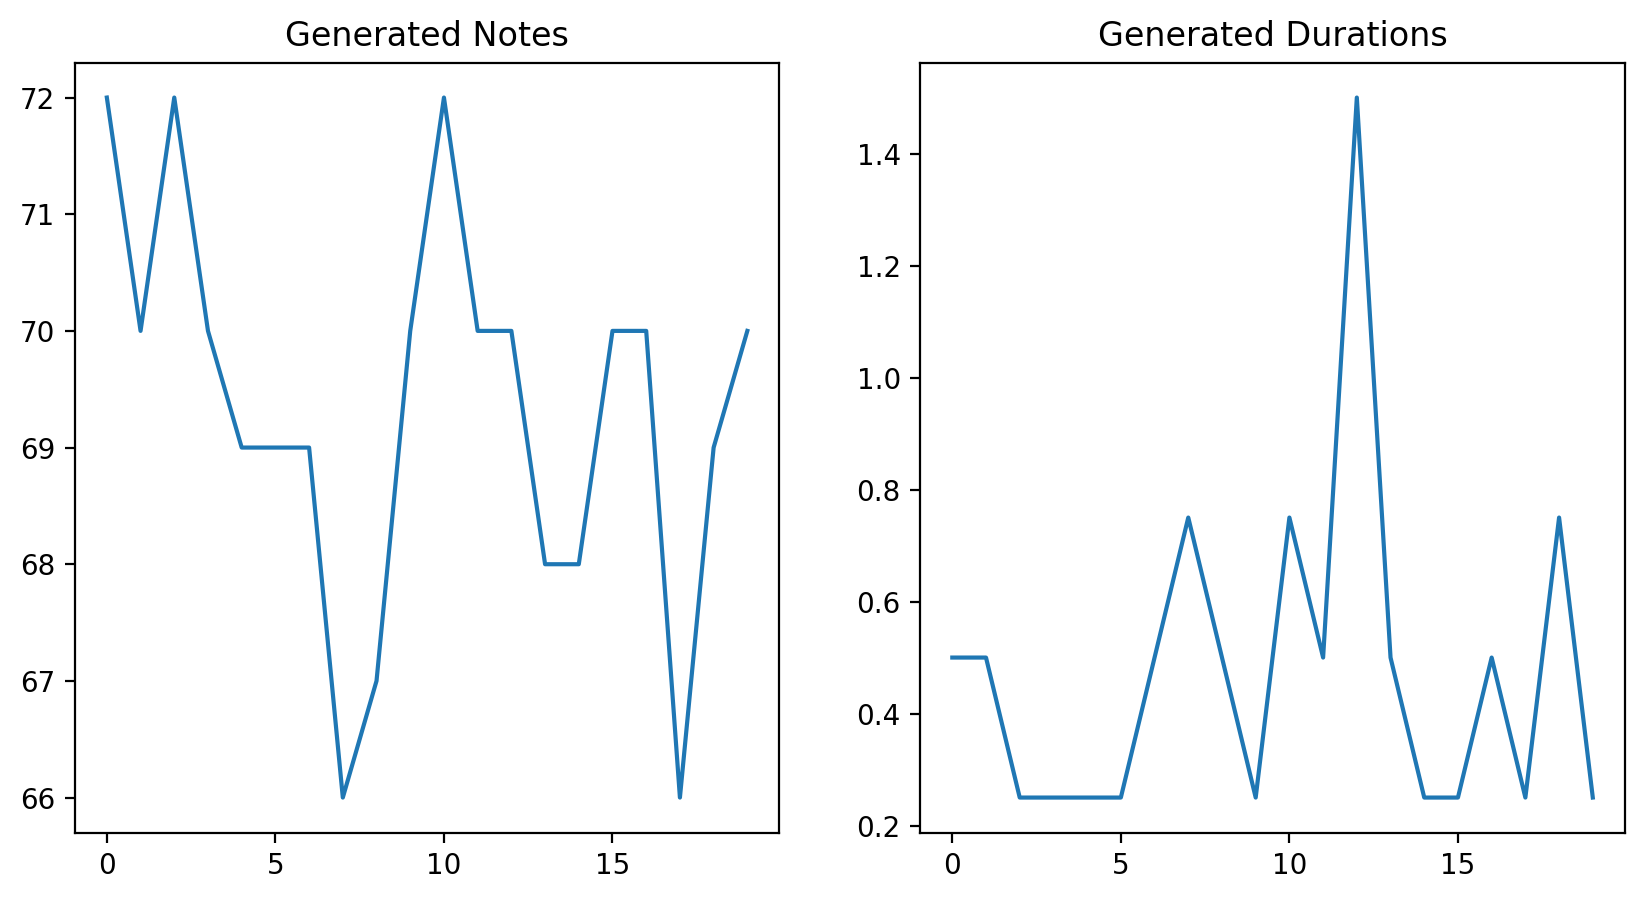

In [92]:
# Décodage des séquences générées
generated_notes = generated_notes[0]
generated_durations = generated_durations[0]
generated_notes = generated_notes * (99 - 50) + 50
generated_durations = generated_durations * 7
generated_notes = generated_notes.astype(int)
generated_durations = generated_durations.astype(int)
generated_durations = decode_duration_float(generated_durations)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Generated Notes")
plt.plot(generated_notes)
plt.subplot(1, 2, 2)
plt.title("Generated Durations")
plt.plot(generated_durations)
plt.show()

---Notes encodés---


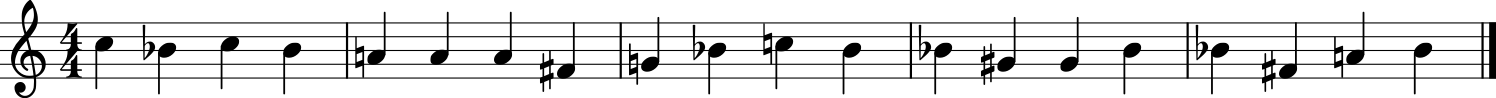

---Rythmes encodés---


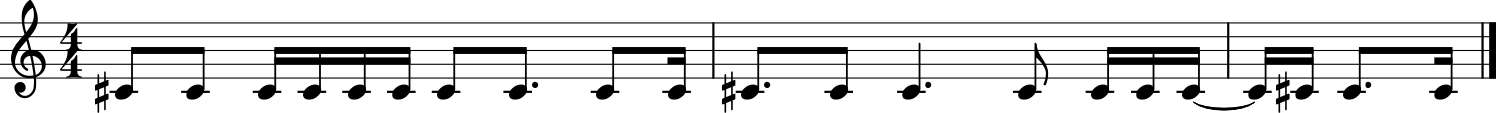

In [93]:
# Construction d'une melodie
song = (generated_notes, generated_durations)

notes, durations = show_encoded_song(song)
notes.show("midi")
durations.show("midi")

In [94]:
decoded_song = decode_song(song)
decoded_song.show("midi")